In [39]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


## 1. Выполните сохранение монохромного изображения в виде текстового или бинарного файла.

Размер исходного массива: 65536 байт


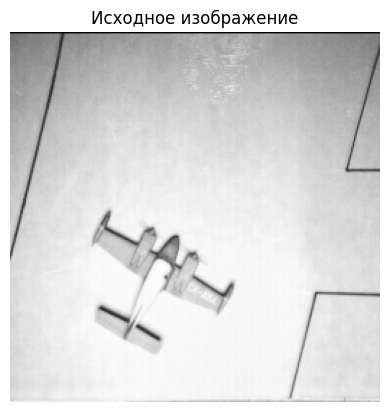

In [40]:
# Настройки и загрузка исходного изображения
image_basename = "plane"
image_ext = "tiff"
image_fullname = f"{image_basename}.{image_ext}"

# Загружаем изображение в оттенках серого
image = cv2.imread(image_fullname, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Не удалось открыть файл {image_fullname!r}")

print(f"Размер исходного массива: {image.nbytes} байт")
plt.imshow(image, cmap="gray")
plt.title("Исходное изображение")
plt.axis("off")
plt.show()


In [41]:
# Сохранение изображения как текстового файла
np.savetxt(f"{image_basename}_text.txt", image, fmt="%d")


## 2. Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.

In [42]:
def haar_wavelet_transform(gray_image: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    gray_image = gray_image.astype(np.float32)

    height, width = gray_image.shape
    if height % 2 != 0 or width % 2 != 0:
        raise ValueError("Размеры изображения должны быть чётными для преобразования Хаара.")

    # Преобразование по строкам
    temp = np.zeros_like(gray_image, dtype=np.float32)
    half_width = width // 2
    for row in range(height):
        for col in range(half_width):
            left = gray_image[row, 2 * col]
            right = gray_image[row, 2 * col + 1]
            avg = (left + right) / 2.0
            diff = (left - right) / 2.0
            temp[row, col] = avg
            temp[row, col + half_width] = diff

    # Преобразование по столбцам
    result = np.zeros_like(temp, dtype=np.float32)
    half_height = height // 2
    for col in range(width):
        for row in range(half_height):
            top = temp[2 * row, col]
            bottom = temp[2 * row + 1, col]
            avg = (top + bottom) / 2.0
            diff = (top - bottom) / 2.0
            result[row, col] = avg
            result[row + half_height, col] = diff

    # Разделяем матрицу на поддиапазоны частот
    ll = result[:half_height, :half_width]   # низкие частоты (приближение)
    lh = result[:half_height, half_width:]   # горизонтальные детали
    hl = result[half_height:, :half_width]   # вертикальные детали
    hh = result[half_height:, half_width:]   # диагональные детали

    return ll, lh, hl, hh


ll, lh, hl, hh = haar_wavelet_transform(image.copy())


## 3. Выполните квантование высокочастотных компонент (прим., количество квантов = 4).

In [43]:
def quantize(component: np.ndarray, levels: int = 4) -> np.ndarray:
    """Квантование значений компоненты в заданное число уровней."""
    min_value = component.min()
    max_value = component.max()

    if max_value == min_value:
        # Вся матрица константна, можно вернуть нули
        return np.zeros_like(component, dtype=int)

    step = (max_value - min_value) / levels
    quantized = np.round((component - min_value) / step).astype(int)
    quantized = np.clip(quantized, 0, levels - 1)
    return quantized


lh_q = quantize(lh)
hl_q = quantize(hl)
hh_q = quantize(hh)


## 4. Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL, LH, HL, HH вейвлет-преобразования Хафа. Компоненты LH, HL, HH храните в виде пар (значение, количество повторений).

In [44]:
from itertools import groupby


def pair_encode(data: np.ndarray) -> list[tuple[int, int]]:
    flat = data.flatten()
    encoded_pairs: list[tuple[int, int]] = []

    for value, group in groupby(flat):
        count = len(list(group))
        encoded_pairs.append((int(value), int(count)))

    return encoded_pairs


# Запись компонент в файл
with open(f"{image_basename}_compressed.txt", "w", encoding="utf-8") as file:
    # Полностью сохраняем LL-компоненту в текстовом виде
    file.write("LL:\n")
    np.savetxt(file, ll, fmt="%.4f")

    # Остальные компоненты кодируем попарно (RLE)
    components = {
        "LH": lh_q,
        "HL": hl_q,
        "HH": hh_q,
    }

    for name, component in components.items():
        file.write(f"\n{name}:\n")
        for value, count in pair_encode(component):
            file.write(f"{value} {count}\n")


## Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение), и изображение, полученным после преобразования Хафа и сжатием длин серий.

In [45]:
import os

original_text_size = os.path.getsize(f"{image_basename}_text.txt")
compressed_text_size = os.path.getsize(f"{image_basename}_compressed.txt")

print(f"Размер исходного текстового файла: {original_text_size} байт")
print(f"Размер сжатого файла: {compressed_text_size} байт")
compression_ratio = original_text_size / compressed_text_size
print(f"Коэффициент сжатия: {compression_ratio:.2f}")


Размер исходного текстового файла: 260853 байт
Размер сжатого файла: 155883 байт
Коэффициент сжатия: 1.67


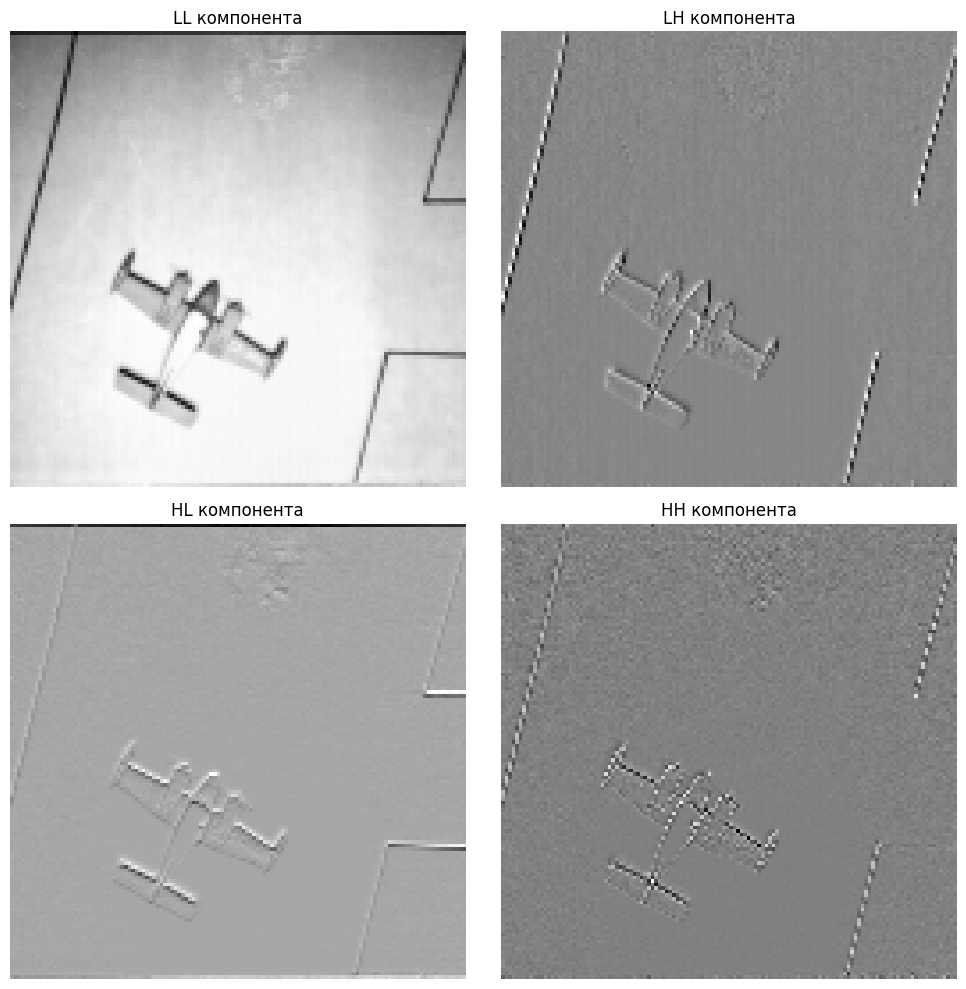

In [46]:
components = {
    "LL": ll,
    "LH": lh,
    "HL": hl,
    "HH": hh,
}

plt.figure(figsize=(10, 10))

for index, (name, component) in enumerate(components.items(), start=1):
    plt.subplot(2, 2, index)
    plt.imshow(component, cmap="gray")
    plt.title(f"{name} компонента")
    plt.axis("off")

plt.tight_layout()
plt.show()
